In [4]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

from itertools import product
from matplotlib.lines import Line2D
import midynet.utility.display as display
from midynet.statistics import Statistics


from pyhectiqlab import Run
run = Run("Numerical validation figure", project="dynamica/midynet")

run.add_dataset_usage(
    "midynet1-duality-data", 
    version="1.0.1", 
)
run.add_artifact("numerical-validation.ipynb")

display.setup_dir("./")

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = ["."]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
# path_to_data = pathlib.Path("../../../../data/midynet-data/figure3")
path_to_data = pathlib.Path("../../scripts/duality/data/numerical-validation/")



In [5]:
dynamics = "glauber"
methods = ["exact", "meanfield", "annealed"]
sizes = ["small", "large"]
mutualinfo, prior = {}, {}
xaxis = {}
for s, m in product(sizes, methods):
    if m == "exact" and s == "large":
        continue
    name = f"glauber-{s}-{m}"
    df = pd.read_pickle(path_to_data/f"{name}/reconinfo.pkl")[name]
    mutualinfo[s, m] = Statistics.from_dataframe(df, key="mutualinfo")
    prior[s] = df["prior-loc"][0]
    xaxis[s, m] = df["data_model.coupling"]

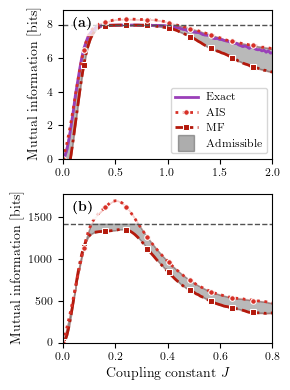

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(3, 4), sharex=False)


color = {
    "exact":display.dark_colors["purple"],
    "meanfield":display.dark_colors["red"],
    "annealed":display.med_colors["red"],
    "lines":display.dark_colors["grey"],
    
}

linestyle = {
    "exact": "solid",
    "annealed": "dotted",
    "meanfield": "dashdot",
}

marker = {
    "exact": "None",
    "annealed": "o",
    "meanfield": "s",
}

for m in methods:
    mutualinfo["small", m].lineplot(
        xaxis["small", m],
        ax=ax[0],
        color=color[m],
        linestyle=linestyle[m],
        marker=marker[m],
        linewidth=2,
        markevery=10,
        markersize=4,
        interpolate="cubic",
    )
handles = [
    display.get_label_line("Exact", style=ax[0].get_lines()[0]),
    display.get_label_line("AIS", style=ax[0].get_lines()[2]),
    display.get_label_line("MF", style=ax[0].get_lines()[1]),
    display.get_label_line(
        "Admissible", color=display.dark_colors["grey"], alpha=0.4, 
        linestyle="None", marker="s", markersize=12),
]

x_mf, y_mf = mutualinfo["small", "meanfield"].interpolate(xaxis["small", "meanfield"], size=500)
x_ais, y_ais = mutualinfo["small", "annealed"].interpolate(xaxis["small", "annealed"], size=500)
ax[0].fill_between(x_mf, y_mf.loc, np.clip(y_ais.loc, 0, prior["small"]), color=display.med_colors["grey"], alpha=0.4)
ax[0].axhline(prior["small"], linestyle="--", color=display.med_colors["grey"])
ax[0].set_xlabel(None)
ax[0].set_ylabel(r"Mutual information [bits]", fontsize=display.fontsizes["label"])
ax[0].set_xlim([0, 2])
ax[0].set_ylim([0, ax[0].get_ylim()[1]])
ax[0].set_xticks([0, 0.5, 1, 1.5, 2])
ax[0].tick_params(axis="both", labelsize=display.fontsizes["tick"])
ax[0].legend(handles=handles, fontsize=display.fontsizes["legend"])
display.Label.plot(ax[0], fontsize=display.fontsizes["label"], loc="top left")


for m in methods:
    if m == "exact":
        continue
    mutualinfo["large", m].lineplot(
        xaxis["large", m],
        ax=ax[1],
        color=color[m],
        linestyle=linestyle[m],
        marker=marker[m],
        linewidth=2,
        markevery=10,
        markersize=4,
        interpolate="cubic",
    )
x_mf, y_mf = mutualinfo["large", "meanfield"].interpolate(xaxis["large", "meanfield"], size=500)
x_ais, y_ais = mutualinfo["large", "annealed"].interpolate(xaxis["large", "annealed"], size=500)
ax[1].fill_between(x_mf, y_mf.loc, np.clip(y_ais.loc, 0, prior["large"]), color=display.med_colors["grey"], alpha=0.4)
ax[1].axhline(prior["large"], linestyle="--", color=display.med_colors["grey"])
ax[1].set_xlabel(r"Coupling constant $J$", fontsize=display.fontsizes["label"])
ax[1].set_ylabel(r"Mutual information [bits]", fontsize=display.fontsizes["label"])
ax[1].set_xlim([0, 0.8])
ax[1].set_ylim([0, ax[1].get_ylim()[1]])
ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax[1].tick_params(axis="both", labelsize=display.fontsizes["tick"])
display.Label.plot(ax[1], fontsize=display.fontsizes["label"], loc="top left")
display.Label.clear()

fig.tight_layout()

for p, fmt in product(paths_to_figures, ["svg", "pdf", "png"]):
    fig.savefig(p / fmt / f"numerical-validation.{fmt}", bbox_inches='tight')

run.add_figure(fig, "numerical-validation")